In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter, defaultdict
import community.community_louvain as community_louvain
import numpy as np
import re

Number of self-loops: 48
Number of nodes: 1762
Number of edges: 2911


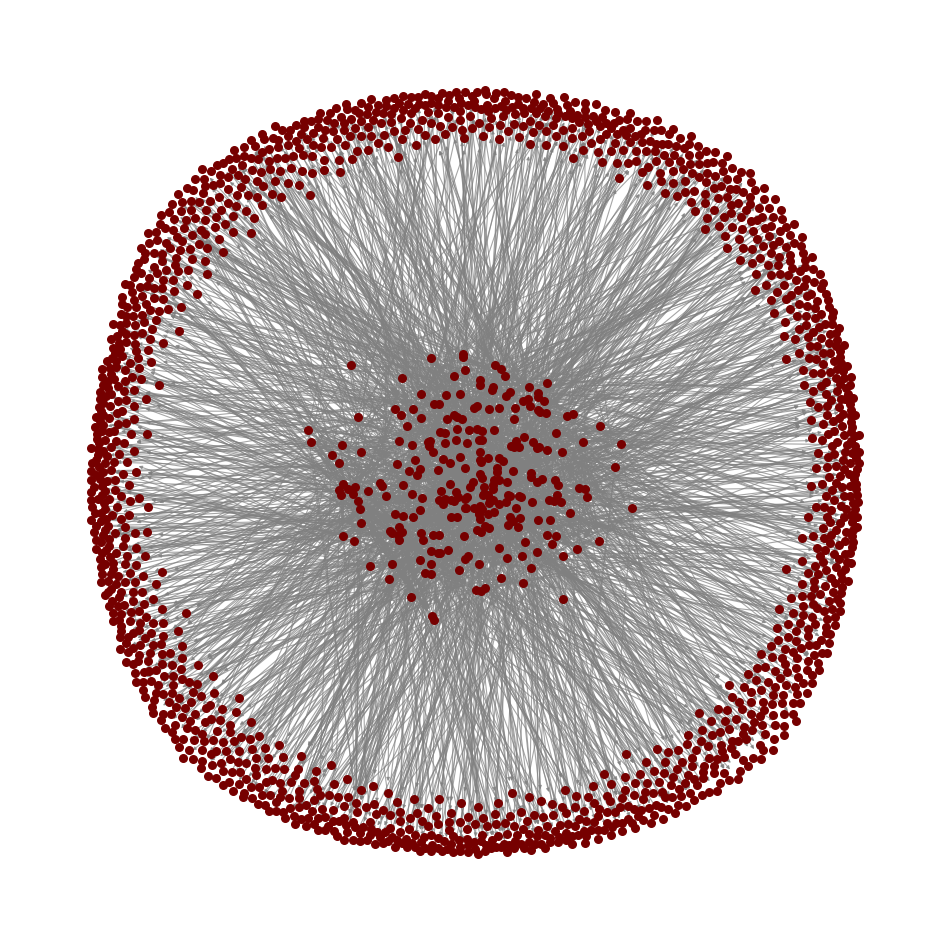

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('csv/bottom_movie_data_with_similar.csv')

# Create an empty directed graph
D = nx.DiGraph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    D.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        D.add_edge(film, similar_film)

# Delete self-loops
self_loops = list(nx.selfloop_edges(D))
print("Number of self-loops:", len(self_loops))
D.remove_edges_from(self_loops)

# Num of nodes and edges
print("Number of nodes:", D.number_of_nodes())
print("Number of edges:", D.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(D, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(D, pos, edge_color='gray', alpha=0.7, width=0.8, arrowsize=5)
nx.draw_networkx_nodes(D, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Directed', fontsize=15)
plt.axis('off')
plt.show()

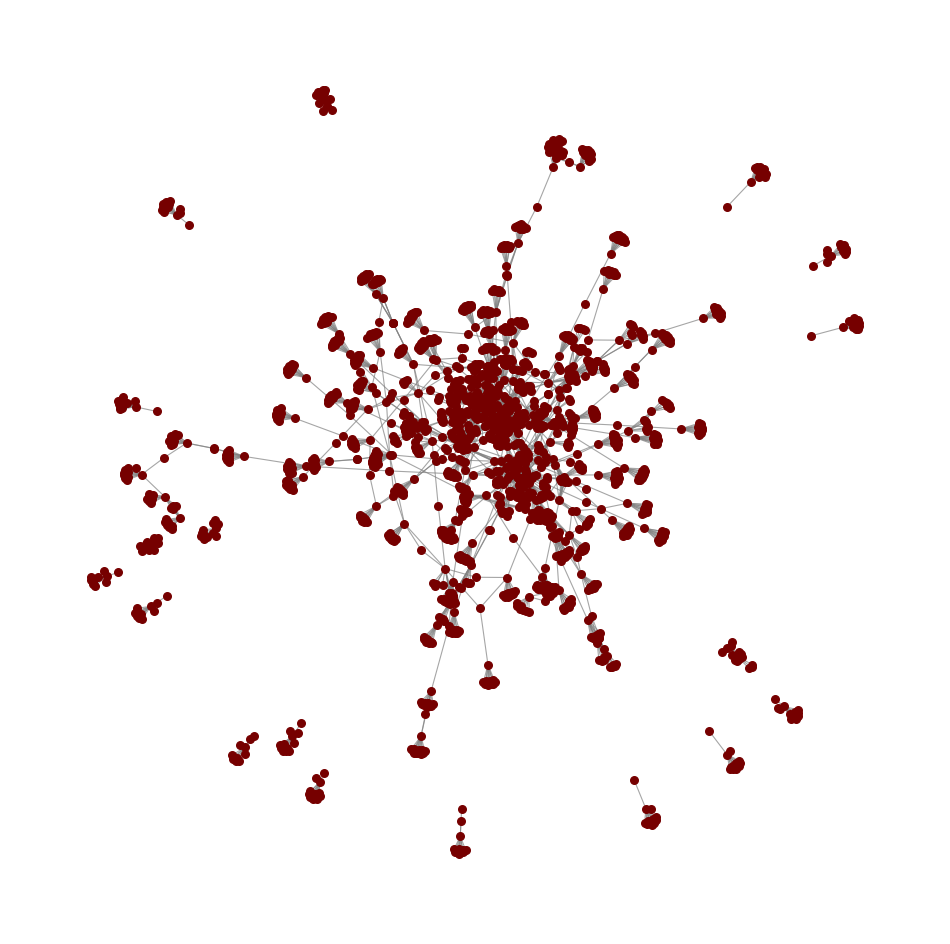

In [3]:
# Make undirected graph
G = D.to_undirected()

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(G, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Undirected', fontsize=15)
plt.axis('off')
plt.show()

Number of nodes: 1138
Number of edges: 1738


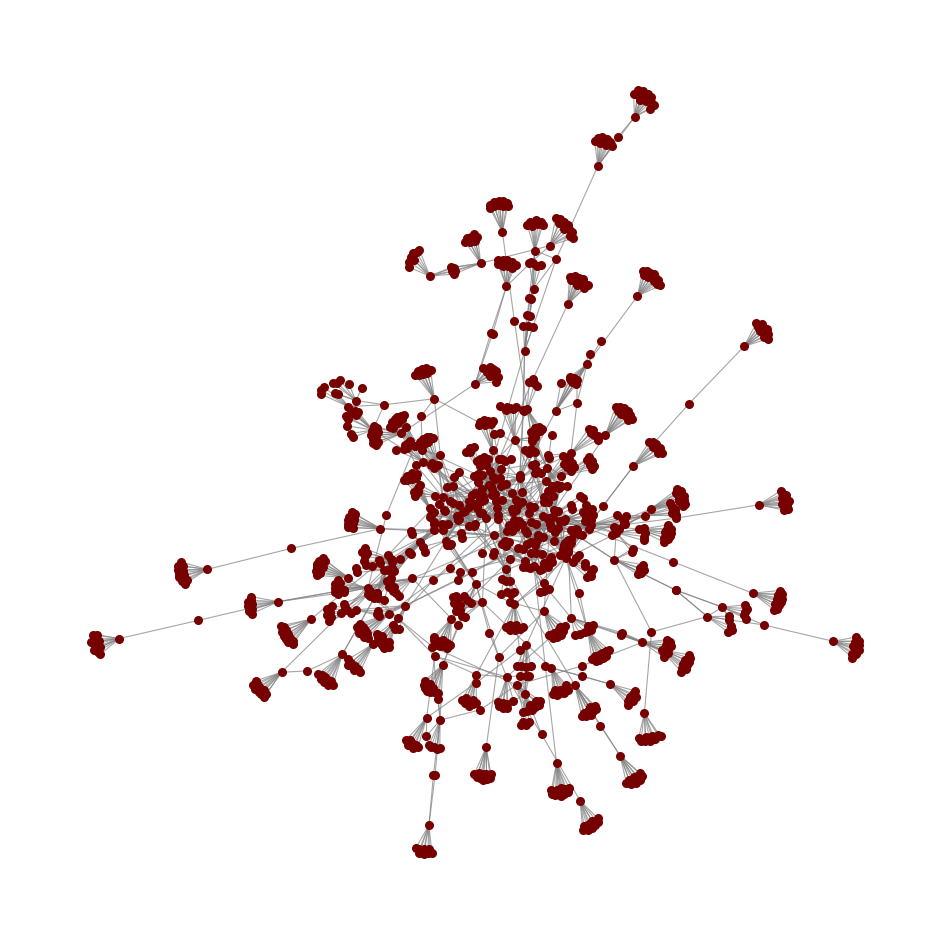

In [4]:
# keep only the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

# Num of nodes and edges
print("Number of nodes:", G_largest.number_of_nodes())
print("Number of edges:", G_largest.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(G_largest, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(G_largest, pos, edge_color='gray', alpha=0.7, width=0.8)
nx.draw_networkx_nodes(G_largest, pos, node_color='#760000', node_size=30)

# plt.title('Bottom Movies Undirected', fontsize=15)
plt.axis('off')
plt.show()

In [11]:
# Folder containing the text files
metadata_folder = 'C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/bottom_net_movies_info'

# Function to parse a metadata text file and exclude the "Synopsis" field
def parse_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        key = None
        for line in lines:
            line = line.strip()
            if line.endswith(':'):
                key = line[:-1]  # Remove the colon
                if key == 'Synopsis':  # Skip "Synopsis"
                    key = None
                else:
                    metadata[key] = ''
            elif key:  # Append the value to the current key
                metadata[key] += (' ' + line if metadata[key] else line)
    return metadata

# Add metadata to the nodes in the graph
for node in G_largest.nodes():
    # First, assume the filename matches the node title directly
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        flag = False
        if node == "The Room Actors: Where Are They Now?":
            sanitized_node = "The Room Actors_ Where Are They Now_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
            flag = True
        if node == "Enes Batur: Imagination or Reality?":
            sanitized_node = "Enes Batur_ Imagination or Reality_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
            flag = True
        if node == "Naked Gun 33 1/3: The Final Insult":
            sanitized_node = "Naked Gun 33 1_3_ The Final Insult"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
            flag = True
        elif not flag:
            for char in [':', '?', '/']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(G_largest, {node: metadata})
    else:
        print(f"Metadata file not found for {node}")

In [12]:
# Check attributes of a specific node
sample_node = "Meet the Blacks"
if sample_node in G_largest.nodes:
    # Print the metadata of the node in one line each
    for key, value in G_largest.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Meet the Blacks 
Rating: 4.8 
Top 250 Rank: N/A 
Duration: 94 
Release Date: 01 Apr 2016 (USA) 
Genres: Comedy, Horror 
Director: Deon Taylor 
Actors: Mike Epps, Gary Owen, Zulay Henao, Bresha Webb, Lil Duval, Paul Mooney, Charlie Murphy, Phil Austin, Andrew Bachelor, Lavell Crawford 
Languages: English 
Description: The Black family is getting out of Chicago in hopes of a better life. After Carl Black (Mike Epps) comes into some unexpected funds, he takes his family and leaves the hustling lifestyle behind for something better. Carl, his new wife Lorena (Zulay Henao), son Carl Jr., daughter Allie Black (Bresha Webb) and cousin Cronut (Lil Duval) pack up and move to Beverly Hills. Turns out, Carl couldn't have picked a worse time to move. They arrive right around the time of the annual purge, when all crime is legal for twelve hours. 
Plot: ["As Carl Black gets the opportunity to move his family out of Chicago in hope of a better life, their arrival in Beverly Hills is timed wit

In [13]:
# Modify the nodes info to get it as list instead of string
G2 = nx.Graph(G_largest)

# Modify the nodes to have lists of genres and directors
for node in G2.nodes:
    # Get the current node data
    data = G2.nodes[node]
    
    # Get the genres and directors as strings
    genres = data.get("Genres", "")
    directors = data.get("Director", "")
    actors = data.get("Actors", "")
    producers = data.get("Producer", "")
    production_companies = data.get("Production Companies", "")
    
    # Split the strings into lists
    genres_list = [g.strip() for g in genres.split(",")] if genres else []
    directors_list = [d.strip() for d in directors.split(",")] if directors else []
    actors_list = [a.strip() for a in actors.split(",")] if actors else []
    producers_list = [p.strip() for p in producers.split(",")] if producers else []
    production_companies_list = [pc.strip() for pc in production_companies.split(",")] if production_companies else []

    # Update the node data with the lists
    data["Genres"] = genres_list
    data["Director"] = directors_list
    data["Actors"] = actors_list
    data["Producer"] = producers_list
    data["Production Companies"] = production_companies_list

# Check the updated node data for a sample node
sample_node = "Meet the Blacks"
if sample_node in G2.nodes:
    # Print the metadata of the node in one line each
    for key, value in G2.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Meet the Blacks 
Rating: 4.8 
Top 250 Rank: N/A 
Duration: 94 
Release Date: 01 Apr 2016 (USA) 
Genres: ['Comedy', 'Horror']
Director: ['Deon Taylor']
Actors: ['Mike Epps', 'Gary Owen', 'Zulay Henao', 'Bresha Webb', 'Lil Duval', 'Paul Mooney', 'Charlie Murphy', 'Phil Austin', 'Andrew Bachelor', 'Lavell Crawford']
Languages: English 
Description: The Black family is getting out of Chicago in hopes of a better life. After Carl Black (Mike Epps) comes into some unexpected funds, he takes his family and leaves the hustling lifestyle behind for something better. Carl, his new wife Lorena (Zulay Henao), son Carl Jr., daughter Allie Black (Bresha Webb) and cousin Cronut (Lil Duval) pack up and move to Beverly Hills. Turns out, Carl couldn't have picked a worse time to move. They arrive right around the time of the annual purge, when all crime is legal for twelve hours. 
Plot: ["As Carl Black gets the opportunity to move his family out of Chicago in hope of a better life, their arrival 

## Sentiment analysis

In [14]:
# Load the CSV containing movie names and keywords
# keywords_df = pd.read_csv("bottom_250_scraped_keywords_with_names.csv")

keywords_df = pd.read_csv("C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/bottom_250_scraped_keywords_with_names.csv")

# Initialize a dictionary to store keyword counts by genre
keyword_genre_counts = defaultdict(lambda: defaultdict(int))  # {keyword: {genre: count}}

# Loop through each movie in the CSV
for _, row in keywords_df.iterrows():
    movie_name = row['Name']  # Name of the movie
    keywords = row['keywords'].split(", ")  # List of keywords for the movie

    # Get the genres associated with the movie from G2
    if movie_name in G2.nodes:
        genres = G2.nodes[movie_name].get("Genres", [])  # Get genres as a list
    else:
        print(f"Movie '{movie_name}' not found in G2. Skipping...")
        continue  # Skip if the movie is not in the graph

    # Count each keyword under the appropriate genres
    for keyword in keywords:
        for genre in genres:
            keyword_genre_counts[keyword][genre] += 1

# Create a list of rows to build the DataFrame
rows = []
for keyword, genre_counts in keyword_genre_counts.items():
    row = {"Keyword": keyword}
    row.update(genre_counts)  # Add genre counts for this keyword
    rows.append(row)

# Convert the list of dictionaries into a DataFrame
genre_counts_df = pd.DataFrame(rows)

# Fill missing values with 0 (keywords that don't appear in some genres)
genre_counts_df.fillna(0, inplace=True)

# Save the resulting DataFrame to a new CSV file
genre_counts_df.to_csv("C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/bottom_250_dictionary.csv", index=False)

Movie 'Home Alone 3' not found in G2. Skipping...
Movie 'Aliens vs. Predator: Requiem' not found in G2. Skipping...
Movie 'Alvin and the Chipmunks: The Squeakquel' not found in G2. Skipping...
Movie 'Kangaroo Jack' not found in G2. Skipping...
Movie 'xXx: State of the Union' not found in G2. Skipping...
Movie 'The Butterfly Effect 2' not found in G2. Skipping...
Movie 'Basic Instinct 2' not found in G2. Skipping...
Movie 'Alvin and the Chipmunks: Chipwrecked' not found in G2. Skipping...
Movie 'Escape Plan: The Extractors' not found in G2. Skipping...
Movie 'Cell' not found in G2. Skipping...
Movie 'Bio-Dome' not found in G2. Skipping...
Movie 'Paul Blart: Mall Cop 2' not found in G2. Skipping...
Movie 'Zoom' not found in G2. Skipping...
Movie 'Stop! Or My Mom Will Shoot' not found in G2. Skipping...
Movie 'Look Who's Talking Now' not found in G2. Skipping...
Movie 'Siberia' not found in G2. Skipping...
Movie 'Artemis Fowl' not found in G2. Skipping...
Movie 'Exposed' not found in G2. 

Unify both datasets

In [31]:
import pandas as pd

# Load the CSV files
file1 = 'C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/bottom_250_dictionary.csv'  # Replace with your first file path
file2 = 'C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/top_250_dictionary.csv'  # Replace with your second file path

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Ensure both datasets have the same columns
all_genres = sorted(set(df1.columns).union(set(df2.columns)) - {'Keyword'})
df1 = df1.set_index('Keyword').reindex(columns=all_genres, fill_value=0.0).reset_index()
df2 = df2.set_index('Keyword').reindex(columns=all_genres, fill_value=0.0).reset_index()

# Combine the datasets and sum values for overlapping keywords and genres
merged_df = pd.concat([df1, df2]).groupby('Keyword', as_index=False).sum()

# Export to a new CSV file
merged_df.to_csv('unified_dictionary.csv', index=False)

In [32]:
# Assuming your genre dictionary is in CSV or can be converted to CSV format
genre_df = pd.read_csv('C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/unified_dictionary.csv')

# Check the format of your genre dataframe
print(genre_df.head())

            Keyword  Action  Adventure  Animation  Biography  Comedy  Crime  \
0       10 year old     0.0        1.0        1.0        0.0     0.0    0.0   
1       11 year old     0.0        0.0        0.0        0.0     0.0    0.0   
2  12 gauge shotgun     0.0        0.0        0.0        0.0     0.0    1.0   
3       12 year old     0.0        1.0        0.0        0.0     1.0    0.0   
4   12 year old boy     0.0        1.0        0.0        0.0     1.0    0.0   

   Documentary  Drama  Family  ...  Music  Musical  Mystery  Romance  Sci-Fi  \
0          0.0    0.0     1.0  ...    0.0      0.0      1.0      0.0     0.0   
1          0.0    1.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   
2          0.0    1.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   
3          0.0    2.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   
4          0.0    2.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   

   Short  Sport  Thriller  War  Western  
0 

In [33]:
# Extract the genres associated with each keyword from genre_df
def create_keyword_genre_mapping(genre_df):
    keyword_genre_mapping = {}
    for _, row in genre_df.iterrows():
        keyword = row['Keyword']
        for genre in genre_df.columns[1:]:  # Skip 'Keyword' column
            if row[genre] > 0:  # If there's a score for this genre, add the keyword to this genre
                if keyword not in keyword_genre_mapping:
                    keyword_genre_mapping[keyword] = []
                keyword_genre_mapping[keyword].append(genre)
    return keyword_genre_mapping

# Create a keyword-to-genres mapping from the genre DataFrame
keyword_genre_mapping = create_keyword_genre_mapping(genre_df)

# Check the keyword-to-genres mapping for a sample keyword
sample_keyword = "love"
if sample_keyword in keyword_genre_mapping:
    print(f"Genres associated with '{sample_keyword}': {keyword_genre_mapping[sample_keyword]}")
else:
    print(f"'{sample_keyword}' not found in the keyword-genre mapping.")

    

Genres associated with 'love': ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [39]:
def create_keyword_genre_mapping(genre_df):
    keyword_genre_mapping = {}
    
    # Loop through each row of the genre_df
    for _, row in genre_df.iterrows():
        keyword = row['Keyword']
        
        # Get the maximum score across all genres for this keyword
        max_score = row[1:].max()  # Get the maximum score (ignores the 'Keyword' column)

        # Find the genres that have the max score
        genres_with_max_score = row[1:][row[1:] == max_score].index.tolist()
        
        # Store the keyword and its associated genres
        keyword_genre_mapping[keyword] = genres_with_max_score
    
    return keyword_genre_mapping

# Example usage with your genre_df
keyword_genre_mapping = create_keyword_genre_mapping(genre_df)

# Print the mapping for a sample keyword
sample_keyword = "prison"
if sample_keyword in keyword_genre_mapping:
    print(f"Genres associated with '{sample_keyword}': {keyword_genre_mapping[sample_keyword]}")
else:
    print(f"'{sample_keyword}' not found in the keyword-genre mapping.")


Genres associated with 'prison': ['Drama']


In [42]:
# Path to the directory containing text files
dir_path = "C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/net_movies_info/net_movies_info"

# Function to extract the synopsis from a file
def extract_synopsis(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Use a regular expression to extract the synopsis (assuming it's between "Synopsis:" and "]")
    match = re.search(r'Synopsis:\s*\[(.*?)\]', content, re.DOTALL)
    if match:
        synopsis = match.group(1)
        return synopsis
    else:
        return ""

# Get a list of all files in the directory
files = os.listdir(dir_path)

# Extract synopses from each file
synopses = {}
for file in files:
    file_path = os.path.join(dir_path, file)
    if os.path.isfile(file_path):
        synopsis = extract_synopsis(file_path)
        # You can associate the synopsis with the movie name, here we use the file name as the movie name
        movie_name = os.path.splitext(file)[0]
        synopses[movie_name] = synopsis

# Preview the extracted synopses with a example
#print(synopses['Wishmaster'])


In [44]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Clean all synopses
for movie, synopsis in synopses.items():
    synopses[movie] = clean_text(synopsis)

# Preview the cleaned synopses in a example
# print(synopses['Wishmaster'])

In [46]:
def calculate_genre_percentages(synopsis, keyword_genre_mapping):
    # Clean the synopsis and split into words
    cleaned_synopsis = clean_text(synopsis)
    words = cleaned_synopsis.split()  # All words in the synopsis (not unique)
    #words = set(cleaned_synopsis.split())  # Unique words in the synopsis
    
    genre_counts = Counter()  # To store genre counts
    total_keywords = 0  # To store the total number of genre-related keywords found
    
    # For each word in the cleaned synopsis, check if it's a keyword and if so, count it in its genres
    for word in words:
        if word in keyword_genre_mapping:
            genres = keyword_genre_mapping[word]
            total_keywords += len(genres)  # Increment total for each genre match
            for genre in genres:
                genre_counts[genre] += 1
    
    # Calculate the genre percentages
    if total_keywords == 0:  # If no genre-related keywords are found
        return {genre: 0 for genre in genre_counts}
    
    genre_percentages = {genre: (count / total_keywords) * 100 for genre, count in genre_counts.items()}
    
    return genre_percentages

# Loop through all movies and calculate their genre percentages based on their synopses
movie_genre_percentages = {}

for movie_name, synopsis in synopses.items():
    genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
    movie_genre_percentages[movie_name] = genre_percentages

# Preview the results for one movie
#print(movie_genre_percentages.get('Wishmaster', {}))


In [47]:
# Calculate genre percentages and organize from top to bottom for each film
def process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file):
    movie_genre_percentages = []

    for movie_name, synopsis in synopses.items():
        # Calculate percentages for the movie
        genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
        # Sort genres by percentage in descending order
        sorted_genres = sorted(genre_percentages.items(), key=lambda x: x[1], reverse=True)
        # Prepare data for saving
        movie_genre_percentages.append({
            "Movie": movie_name,
            "Top Genre": sorted_genres[0][0] if sorted_genres else None,  # Highest percentage genre
            "Top Percentage": sorted_genres[0][1] if sorted_genres else 0,  # Highest percentage
            "All Genres": ", ".join([f"{genre}: {percentage:.2f}%" for genre, percentage in sorted_genres])  # Full list
        })

    # Convert to DataFrame and save
    result_df = pd.DataFrame(movie_genre_percentages)
    result_df.to_csv(output_file, index=False)
    print(f"Genre percentages saved to {output_file}")

# Run the function and save the results
output_file = "movie_genre_percentages_Top.csv"
process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file)


Genre percentages saved to movie_genre_percentages_Top.csv
